# Analysis of Reddit comments based on TF-IDF using PySpark

In [ ]:
from pyspark.sql import SparkSession, SQLContext
import time
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF
import numpy as np
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Connnect to Spark cluster and load data

In [ ]:
spark_session = SparkSession.builder\
    .master("spark://192.168.2.41:7077")\
    .appName("sentiment analysis")\
    .config("spark.dynamicAllocation.enabled", True)\
    .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
    .config("spark.shuffle.service.enabled", False)\
    .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
    .config("spark.cores.max", 8)\
    .getOrCreate()

sql_context = SQLContext(spark_session.sparkContext)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/14 17:06:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Loads the Reddit dataset containing comments as JSON documents from HDFS into a DataFrame 
# and stores it in cache memory to increase speed.
comments = sql_context.read.json('hdfs://192.168.2.245:9000/group-9/RC_2011-01').cache()

In [ ]:
# Initialize timer
start_time = time.process_time()

## Data exploration

In [ ]:
# Prints the schema of the Reddit comments. 
comments.printSchema()

root
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- score_hidden: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



In [ ]:
# Removes comments without an author. 
comments = comments.filter(col('author') != '[deleted]')

In [ ]:
# Extracts the body and score of the of the Reddit comments. 
comments = comments.select(col('body'), col('score'))

In [ ]:
# Spark to Pandas dataframe
pandas_converted = comments.groupBy('score').agg(count('body').alias('count')).sort('score').toPandas()

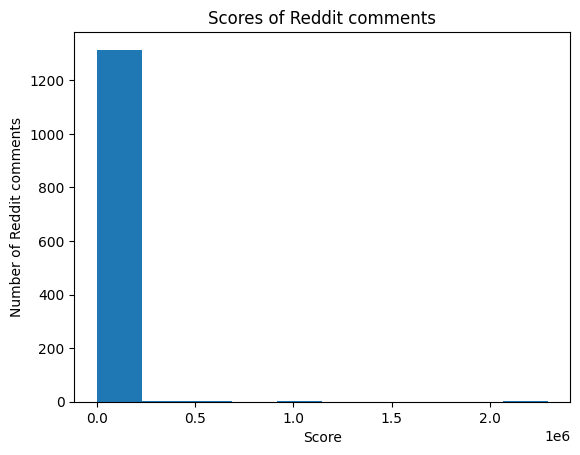

In [ ]:
# Plots the scores of all the Reddit comments.
#pandas_converted.plot.bar(x='score', y='count', legend=None)
pandas_converted['count'].plot(kind='hist')
plt.title('Scores of Reddit comments')
plt.ylabel('Number of Reddit comments')
plt.xlabel('Score')
plt.show()

## Compute sentiments

In [ ]:
# Converts the score to either of the 2 sentiments: 0 (negative), or 1 (positive).
def sentiment(score):
    if score < 0:
        return 0
    if score > 0:
        return 1

# Defines an UDF for the sentiment() function
udf_sentiment = udf(lambda score: sentiment(score), IntegerType())

# Calculates the sentiment for each score. 
comments = comments.filter(col('score') != 0).select(col('body'), udf_sentiment(col('score')).alias('sentiment'))

comments.show()

+--------------------+---------+
|                body|sentiment|
+--------------------+---------+
|They should add t...|        1|
|Beta has nothing ...|        1|
|&gt;Actually perh...|        1|
|So many votes, an...|        1|
|Heee, I just imag...|        1|
|I love the idea. ...|        1|
|&gt;turned out to...|        0|
|Upvoting because ...|        0|
|I have the same r...|        1|
|I'm female. Ergo,...|        1|
|I'm black and I l...|        1|
|One benefit is it...|        1|
|If scoped correct...|        1|
|The issue is that...|        1|
|Just ask me, I ca...|        1|
|I would suggest c...|        1|
|You are correct, ...|        1|
|Dude, don't screw...|        0|
|Why does he start...|        1|
|So why is that an...|        0|
+--------------------+---------+
only showing top 20 rows



## Data visualization

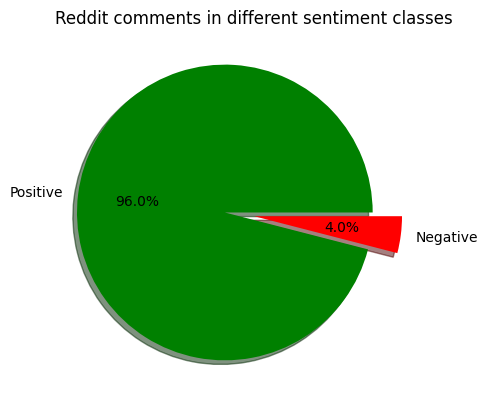

In [ ]:
sentiments = comments.groupBy('sentiment').agg(count('body').alias('count')).sort('sentiment').collect()
negative = sentiments[0][1]
positive = sentiments[1][1]

myexplode = [0.2, 0]
plt.pie([positive, negative], labels=['Positive', 'Negative'], explode = myexplode, shadow = True, colors=['g', 'r'], autopct='%1.1f%%')
plt.title('Reddit comments in different sentiment classes')
plt.show()

## Pre-processing

In [ ]:
# Pre-processes the comments.
def preprocess(comments):
    
    # Tokenization
    tokenizer = RegexTokenizer(inputCol="body", outputCol="tokens", pattern="\\W+")
    tokenized = tokenizer.transform(comments)
    
    # Stop words removal
    add_stopwords = ["http","https","amp","rt","t","c","the","@","/",":"] # standard web stop words
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens").setStopWords(add_stopwords)
    filtered = stopwords_remover.transform(tokenized)
    
    return filtered

In [ ]:
# Preprocesses the comment in the Reddit dataset.
comments = preprocess(comments)
comments.show()

+--------------------+---------+--------------------+--------------------+
|                body|sentiment|              tokens|     filtered_tokens|
+--------------------+---------+--------------------+--------------------+
|They should add t...|        1|[they, should, ad...|[they, should, ad...|
|Beta has nothing ...|        1|[beta, has, nothi...|[beta, has, nothi...|
|&gt;Actually perh...|        1|[gt, actually, pe...|[gt, actually, pe...|
|So many votes, an...|        1|[so, many, votes,...|[so, many, votes,...|
|Heee, I just imag...|        1|[heee, i, just, i...|[heee, i, just, i...|
|I love the idea. ...|        1|[i, love, the, id...|[i, love, idea, g...|
|&gt;turned out to...|        0|[gt, turned, out,...|[gt, turned, out,...|
|Upvoting because ...|        0|[upvoting, becaus...|[upvoting, becaus...|
|I have the same r...|        1|[i, have, the, sa...|[i, have, same, r...|
|I'm female. Ergo,...|        1|[i, m, female, er...|[i, m, female, er...|
|I'm black and I l...|   

## Feature engineering

In [ ]:
# Calculates term frequency (tf) for each of the tokens. 
hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features", numFeatures=20)
tf = hashing_tf.transform(comments)

# Calculates term frequency–inverse document frequency (tf-idf) for each of the tokens. 
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(tf)
tfidf = idf_model.transform(tf)

tfidf.select(col('features'), col('sentiment')).show()

+--------------------+---------+
|            features|sentiment|
+--------------------+---------+
|(20,[0,1,2,7,8,16...|        1|
|(20,[0,1,3,5,6,7,...|        1|
|(20,[0,1,2,3,4,5,...|        1|
|(20,[0,1,2,3,4,5,...|        1|
|(20,[0,1,4,7,9,10...|        1|
|(20,[0,1,3,5,6,7,...|        1|
|(20,[2,3,4,5,6,7,...|        0|
|(20,[1,8,11,13,15...|        0|
|(20,[1,3,4,5,6,7,...|        1|
|(20,[3,10,13,14,1...|        1|
|(20,[0,2,3,4,8,10...|        1|
|(20,[0,3,4,6,7,8,...|        1|
|(20,[0,1,2,3,4,5,...|        1|
|(20,[0,1,3,4,5,6,...|        1|
|(20,[0,3,7,9,13,1...|        1|
|(20,[0,1,3,4,5,6,...|        1|
|(20,[0,1,2,3,4,5,...|        1|
|(20,[1,2,3,4,5,6,...|        0|
|(20,[1,3,8,12,13,...|        1|
|(20,[0,3,4,5,9,10...|        0|
+--------------------+---------+
only showing top 20 rows



## Logistic Regression

In [ ]:
# Sets random seed 
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [ ]:
# Splits the data into train and test data
train_data, test_data = tfidf.randomSplit([.7,.3], seed=rnd_seed)

In [ ]:
train_data.count(), test_data.count()

(3500593, 1499668)

### Train the model

In [ ]:
lr = LogisticRegression(featuresCol='features', labelCol='sentiment', predictionCol='predicted_sentiment', 
                        maxIter=500, regParam=0.3, elasticNetParam=0.8, standardization=False)

In [ ]:
# Fit the data to the model
lr = lr.fit(train_data)

### Evaluate the model

In [ ]:
# Evaluate the model on test data
predictions = lr.transform(test_data)
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='sentiment')
auc = evaluator.evaluate(predictions)
print("Area under ROC curve = %g" % auc)

Area under ROC curve = 0.5


### Inspect other metrics

In [ ]:
tp = predictions[(predictions.sentiment == 1) & (predictions.predicted_sentiment == 1)].count()
tn = predictions[(predictions.sentiment == 0) & (predictions.predicted_sentiment == 0)].count()
fp = predictions[(predictions.sentiment == 0) & (predictions.predicted_sentiment == 1)].count()
fn = predictions[(predictions.sentiment == 1) & (predictions.predicted_sentiment == 0)].count()

print("True positive rate = %g" % (tp / (tp + fn)))
print("False positive rate = %g" % (fp / (fp + tn)))
print("Precision = %g" % (tp / (tp + fp)))
print("Recall = %g" % (tp / (tp + fn)))

True positive rate = 1
False positive rate = 1
Precision = 0.959821
Recall = 1


In [ ]:
print(f'Execution time: {time.process_time() - start_time} seconds')

Execution time: 1.362370231 seconds


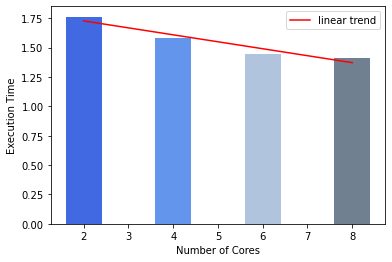

In [5]:
number_cores = [2, 4, 6, 8]
execution_time = [1.7622, 1.5779, 1.4433, 1.4123]

colors = ['royalblue', 'cornflowerblue', 'lightsteelblue', 'slategrey']
plt.bar(number_cores, execution_time, color=colors)
plt.xticks(range(0, 11))
plt.xlabel('Number of Cores')
plt.ylabel('Execution Time')

x = np.array(number_cores)
y = np.array(execution_time)
m, b = np.polyfit(x, y, 1) 
plt.plot(x, m*x + b, color='red', label='linear trend')

plt.legend()
plt.show()


In [ ]:
spark_session.stop()